In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from torch.utils.data import IterableDataset
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [2]:
import os

In [3]:
from dotenv import load_dotenv
load_dotenv()

os.chdir(os.getenv("PROJECT_ROOT_DIR"))
print(os.getcwd())

/home/truonghm/learning/m1-internship/malicious-code-detection


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
class Config:

    BATCH_SIZE = 128
    DEVICE =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    LEARNING_RATE = 2e-5
    EPOCHS = 20
    TEST_PATH = 'data/exp/kaggle12_test_data_word2vec_by_val.parquet'
    TRAIN_PATH = 'data/exp/kaggle12_train_data_word2vec_by_val.parquet'

In [6]:


import numpy as np


class JavaScriptData(IterableDataset):
    def __init__(self, parquet_path, chunk_size=1000, limit=None):
        super(JavaScriptData, self).__init__()
        self.parquet_path = parquet_path
        self.chunk_size = chunk_size
        self.limit = limit

    def read_in_chunks(self):
        with ProgressBar():
            ddf = dd.read_parquet(self.parquet_path)
            n = len(ddf)

        if self.limit is not None:
            n = min(n, self.limit)

        for i in range(0, n, self.chunk_size):
            with ProgressBar():
                # The following line ensures that we only read up to self.limit rows
                end_row = min(i + self.chunk_size - 1, self.limit - 1) if self.limit is not None else i + self.chunk_size - 1
                chunk = ddf.loc[i:end_row].compute()
            yield chunk

    def __iter__(self):
        # Read data and yield batches
        for chunk in self.read_in_chunks():
            outputs = torch.tensor(chunk.drop(columns=['label']).values, dtype=torch.float32)
            labels = torch.tensor(chunk['label'].values, dtype=torch.long)
            for output, label in zip(outputs, labels):
                yield output, label



In [7]:
train_dataset = JavaScriptData(Config.TRAIN_PATH, chunk_size=5000, limit=5000)
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, num_workers=0)

test_dataset = JavaScriptData(Config.TEST_PATH, chunk_size=5000, limit=5000)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, num_workers=0)

In [8]:
for outputs, labels in test_loader:
	print(outputs.shape)
	print(labels.shape)

for outputs, labels in train_loader:
	print(outputs.shape)
	print(labels.shape)

[########################################] | 100% Completed | 102.03 ms
[########################################] | 100% Completed | 101.15 ms
torch.Size([100, 100])
torch.Size([100])
[########################################] | 100% Completed | 101.46 ms
[########################################] | 100% Completed | 101.95 ms
torch.Size([128, 100])
torch.Size([128])
torch.Size([128, 100])
torch.Size([128])
torch.Size([128, 100])
torch.Size([128])
torch.Size([128, 100])
torch.Size([128])
torch.Size([128, 100])
torch.Size([128])
torch.Size([128, 100])
torch.Size([128])
torch.Size([128, 100])
torch.Size([128])
torch.Size([104, 100])
torch.Size([104])


In [9]:
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(100, 256)  # 100 input features
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 output classes: malicious or benign

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = BinaryClassifier()

In [10]:
# Assuming that you've already created train_loader and test_loader
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

# Training Loop
for epoch in range(Config.EPOCHS):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Zero gradients, backward pass, optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation Loop
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')

[########################################] | 100% Completed | 102.04 ms
[########################################] | 100% Completed | 101.87 ms
[########################################] | 100% Completed | 101.28 ms
[########################################] | 100% Completed | 101.91 ms
[########################################] | 100% Completed | 101.41 ms
[########################################] | 100% Completed | 102.68 ms
[########################################] | 100% Completed | 101.45 ms
[########################################] | 100% Completed | 102.07 ms
[########################################] | 100% Completed | 101.77 ms
[########################################] | 100% Completed | 101.99 ms
[########################################] | 100% Completed | 101.15 ms
[########################################] | 100% Completed | 102.10 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 10

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

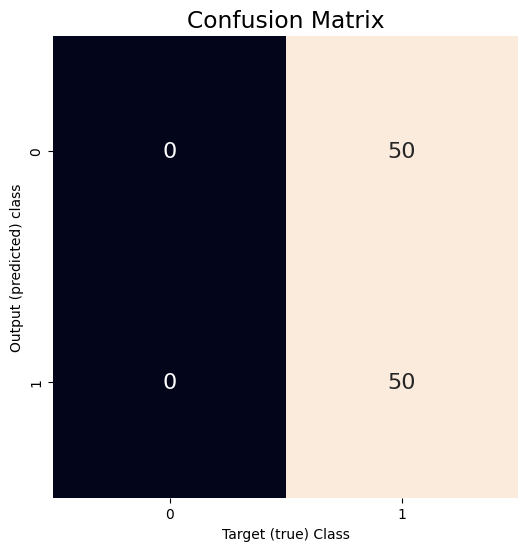

               precision    recall  f1-score   support

non-obfuscted       0.00      0.00      0.00        50
   obfuscated       0.50      1.00      0.67        50

     accuracy                           0.50       100
    macro avg       0.25      0.50      0.33       100
 weighted avg       0.25      0.50      0.33       100



/home/truonghm/learning/m1-internship/malicious-code-detection/.conda/m1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/truonghm/learning/m1-internship/malicious-code-detection/.conda/m1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/truonghm/learning/m1-internship/malicious-code-detection/.conda/m1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

In [12]:
confusion = confusion_matrix(y_true, y_pred)

plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(confusion, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)  # font size
plt.xlabel("Target (true) Class")
plt.ylabel("Output (predicted) class")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=["non-obfuscted", "obfuscated"]))